<a href="https://colab.research.google.com/github/juliasoley/Lokaverkefni-gervigreind/blob/main/V5_1colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os


In [ ]:
import numpy as np

class Connect4Game:
    def __init__(self, rows=4, columns=5, win_length=3):
        """
        Initialize the Connect-4 game board.
        :param rows: Number of rows in the game board.
        :param columns: Number of columns in the game board.
        :param win_length: Number of tokens in a row needed to win.
        """
        self.rows = rows
        self.columns = columns
        self.win_length = win_length
        self.board = np.zeros((rows, columns), dtype=int)

    def reset(self):
        """
        Reset the game board to the initial state.
        :return: The reset game board.
        """
        self.board = np.zeros((self.rows, self.columns), dtype=int)
        return self.board

    def place_token(self, column, player):
        """
        Place a token in the specified column for the given player.
        :param column: The column to place the token in.
        :param player: The player (1 or 2) placing the token.
        :return: The updated board state or None if the move is invalid.
        """
        if column < 0 or column >= self.columns or self.board[0, column] != 0:
            return None  # Invalid move or column full

        for row in range(self.rows-1, -1, -1):
            if self.board[row, column] == 0:
                self.board[row, column] = player
                return self.board

    def check_win(self):
        """
        Check if there is a winner.
        :return: The winning player number or 0 if no winner.
        """
        for row in range(self.rows):
            for col in range(self.columns):
                if self.board[row, col] == 0:
                    continue
                player = self.board[row, col]
                # Check all directions: horizontal, vertical, diagonal
                directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
                for dr, dc in directions:
                    if all(0 <= row + dr * i < self.rows and
                           0 <= col + dc * i < self.columns and
                           self.board[row + dr * i, col + dc * i] == player
                           for i in range(self.win_length)):
                        return player
        return 0

    def is_tie(self):
        """
        Check if the game is a tie (i.e., the board is full with no winner).
        :return: True if the game is a tie, False otherwise.
        """
        return all(self.board[0, col] != 0 for col in range(self.columns)) and self.check_win() == 0

    def possible_actions(self):
        """
        Get a list of possible actions (columns where a token can be placed).
        :return: List of column indices that are not full.
        """
        return [c for c in range(self.columns) if self.board[0, c] == 0]

In [ ]:
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        """
        Initialize the Q-learning agent.
        :param learning_rate: Learning rate.
        :param discount_factor: Discount factor for future rewards.
        :param epsilon: Epsilon value for epsilon-greedy strategy.
        """
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = {}  # Q-table for storing state-action values

    def choose_action(self, state_id, possible_actions, test_mode=False):
        """
        Choose an action based on the current state and the epsilon-greedy strategy.
        :param state_id: Unique identifier for the current state.
        :param possible_actions: List of possible actions in the current state.
        :param test_mode: If True, the agent always chooses the best action.
        :return: Chosen action.
        """
        if not possible_actions:
            return None  # No valid actions available

        if test_mode or random.random() > self.epsilon:
            # Choose the best action based on the Q-table
            q_values = [self.q_table.get((state_id, a), 0) for a in possible_actions]
            max_q = max(q_values)
            actions_with_max_q = [a for a, q in zip(possible_actions, q_values) if q == max_q]
            return random.choice(actions_with_max_q)
        else:
            # Choose a random action for exploration
            return random.choice(possible_actions)

    def get_state_id(self, state):
        """
        Convert a game state into a unique identifier.
        :param state: The current state of the game board.
        :return: A unique identifier for the state.
        """
        return str(state)  # Using the string representation of the board as a unique identifier



    def update_q_table(self, state_id, action, reward, next_state_id, next_possible_actions):
        """
        Update the Q-table based on the action taken and the resultant state.
        :param state_id: The unique identifier for the current state.
        :param action: The action taken.
        :param reward: The reward received.
        :param next_state_id: The unique identifier for the resultant state.
        :param next_possible_actions: Possible actions in the resultant state.
        """
        current_q = self.q_table.get((state_id, action), 0)
        max_future_q = max([self.q_table.get((next_state_id, a), 0) for a in next_possible_actions], default=0)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_future_q - current_q)
        self.q_table[(state_id, action)] = new_q


In [ ]:
def simulate_game(game_env, agent, player1=1, player2=2):
    """
    Simulate a single game of Connect-4 between the agent and a random opponent.
    """
    state = game_env.reset()
    done = False
    current_player = player1

    while not done:
        state_id = agent.get_state_id(state)
        possible_actions = game_env.possible_actions()

        if not possible_actions:  # No more valid moves, game over
            winner = game_env.check_win()
            if winner:
                reward = 1 if winner == player1 else -1
            else:
                reward = -0.5  # It's a tie
            agent.update_q_table(state_id, None, reward, None, possible_actions)
            break

        action = agent.choose_action(state_id, possible_actions)
        next_state = game_env.place_token(action, current_player)

        # Check game status
        winner = game_env.check_win()
        if winner:
            reward = 1 if winner == player1 else -1
            done = True
        elif game_env.is_tie():
            reward =- 0.5  # It's a tie
            done = True
        else:
            reward = 0  # No reward for ongoing game

        next_state_id = agent.get_state_id(next_state) if next_state is not None else None
        agent.update_q_table(state_id, action, reward, next_state_id, possible_actions)

        state = next_state
        current_player = player2 if current_player == player1 else player1

    return reward


In [ ]:
def test_agent(game_env, agent, num_test_episodes, player1=1, player2=2, display_games=False):
    """
    Test the Q-learning agent's performance over a number of episodes.
    """
    win_count = 0
    for episode in range(num_test_episodes):
        state = game_env.reset()
        done = False
        current_player = player1

        while not done:
            state_id = agent.get_state_id(state)
            possible_actions = game_env.possible_actions()

            if not possible_actions:  # No more valid moves, game over
                winner = game_env.check_win()
                if winner == player1:
                    win_count += 1
                break

            if current_player == player1:
                action = agent.choose_action(state_id, possible_actions, test_mode=True)
            else:
                action = random.choice(possible_actions)  # Random move for opponent

            next_state = game_env.place_token(action, current_player)

            winner = game_env.check_win()
            if winner == player1:
                win_count += 1
                done = True
            elif winner != 0:
                done = True
            elif game_env.is_tie():
                done = True

            state = next_state
            current_player = player2 if current_player == player1 else player1

        if display_games:
            print(f"Game {episode + 1}:")
            print(state)
            print("Result: Agent Wins" if winner == player1 else "Result: Agent Loses")

    win_rate = win_count / num_test_episodes
    return win_rate


In [ ]:
learning_rates = [ 0.1, 0.2,0.3]
discount_factors = [0.8, 0.9, 0.95]

epsilon=[0.2,0.5,0.8]

num_episodes=5000
num_test_episodes = 500
best_win_rate = 0
best_params = None

for lr in learning_rates:
    for df in discount_factors:
        for ep in epsilon:
            agent = QLearningAgent(learning_rate=lr, discount_factor=df,epsilon=ep)
            for episode in range(num_episodes):
                simulate_game(game_env, agent)

            win_rate = test_agent(game_env, agent, num_test_episodes)
            if win_rate > best_win_rate:
                best_win_rate = win_rate
                best_params = (lr, df,ep)

print(f"Best parameters: Learning rate = {best_params[0]}, Discount factor = {best_params[1]}, Epsilon = {best_params[2]}")
print(f"Best win rate: {best_win_rate}")


Best parameters: Learning rate = 0.2, Discount factor = 0.9, Epsilon = 0.5
Best win rate: 0.988


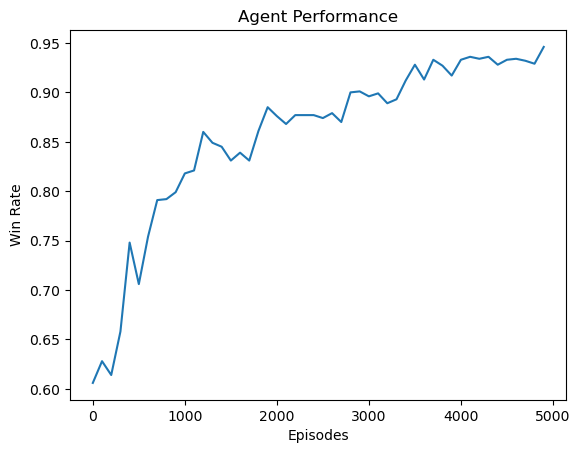

In [ ]:
game_env = Connect4Game()
agent = QLearningAgent(learning_rate=0.2, discount_factor=0.8, epsilon=0.5)

win_rates = []
e=[]
num_episodes = 5000
num_test_episodes = 1000  # Number of episodes to test the agent after each training interval

for episode in range(num_episodes):
    simulate_game(game_env, agent)

    if episode % 100 == 0:
        win_rate = test_agent(game_env, agent, num_test_episodes)
        win_rates.append(win_rate)
        e.append(episode)

plt.plot(e,win_rates)
plt.xlabel('Episodes')
plt.ylabel('Win Rate')
plt.title('Agent Performance')
plt.show()


 # linear approximation for the action-value function (Q)

In [ ]:
def extract_features(game_state, player):
    """
    Extract features from the game board for the given player.
    :param game_board: The game board state.
    :param player: The player number (1 or 2).
    :return: A numpy array of features.
    """
    # Initialize features
    max_tokens_in_a_row = 0
    num_free_slots = np.sum(game_state == 0)
    potential_threats = 0

    # Calculate max_tokens_in_a_row and potential_threats
    # This involves checking rows, columns, and diagonals for consecutive tokens
    # and potential winning spots for the opponent

    # Return features as a numpy array
    return np.array([max_tokens_in_a_row, num_free_slots, potential_threats])

def extract_features(game_state, player):
    # Your existing feature extraction logic



    max_tokens = max_tokens_in_a_row(game_state, player)
    free_slots = np.sum(game_state == 0)
    threats = potential_threats(game_state, player)

    features = np.array([max_tokens, free_slots,threats])

    # Normalize features
    normalized_features = features / np.linalg.norm(features) if np.linalg.norm(features) != 0 else features
    return normalized_features


def max_tokens_in_a_row(game_state, player):
    max_count = 0

    # Check rows and columns
    for i in range(game_state.shape[0]):
        for j in range(game_state.shape[1]):
            # Horizontal
            if j + 3 < game_state.shape[1]:
                count = np.sum(game_state[i, j:j+4] == player)
                max_count = max(max_count, count)
            # Vertical
            if i + 3 < game_state.shape[0]:
                count = np.sum(game_state[i:i+4, j] == player)
                max_count = max(max_count, count)

    # Check diagonals
    for i in range(game_state.shape[0] - 3):
        for j in range(game_state.shape[1] - 3):
            # Diagonal down-right
            count = sum(game_state[i+k, j+k] == player for k in range(4))
            max_count = max(max_count, count)
            # Diagonal up-right
            if i - 3 >= 0:
                count = sum(game_state[i-k, j+k] == player for k in range(4))
                max_count = max(max_count, count)

    return max_count

def potential_threats(game_state, player):
    threat_count = 0
    opponent = 2 if player == 1 else 1

    # Logic to count the number of immediate winning opportunities for the opponent
    # This can be similar to max_tokens_in_a_row but looking for places where opponent has 3 in a row
    # and the 4th spot is empty, indicating a potential win

    return threat_count




In [ ]:
import numpy as np
import random

class LinearQLearningAgent:
    def __init__(self, num_features=3, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        """
        Initialize the Linear Q-Learning agent.
        :param num_features: Number of features used in the linear approximation.
        :param learning_rate: Learning rate for updating weights.
        :param discount_factor: Discount factor for future rewards.
        :param epsilon: Epsilon value for epsilon-greedy strategy.
        """
        self.weights = np.zeros(num_features+1)  # Weights for linear function approximation
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

    def predict_q_value(self, features, action):
        """
        Predict the Q-value for a given state and action using linear function approximation.
        :param features: The feature vector of the current state.
        :param action: The action being considered.
        :return: The predicted Q-value.
        """

        if action is None:
            return 0  # Default Q-value when no action is possible

        # Combine features and action into a single feature vector
        combined_features = np.append(features, action)
        return np.dot(self.weights, combined_features)


    def choose_action(self, state_features, possible_actions, test_mode=False):
        """
        Choose an action based on the current state and the epsilon-greedy strategy.
        :param state_features: Feature vector of the current state.
        :param possible_actions: List of possible actions in the current state.
        :param test_mode: If True, the agent always chooses the best action.
        :return: Chosen action.
        """


        if test_mode or np.random.random() > self.epsilon:
            # Choose the best action based on the predicted Q-values
            q_values = [self.predict_q_value(state_features, a) for a in possible_actions]

            if not q_values:  # If no valid q_values are available
                return None  # Indicate no valid actions

            max_q = max(q_values)
            actions_with_max_q = [a for a, q in zip(possible_actions, q_values) if q == max_q]

            if not actions_with_max_q:  # If no actions have a max Q-value
                return None  # Indicate no valid actions

            return random.choice(actions_with_max_q)


    def update_weights(self, features, action, reward, next_features, next_possible_actions):
        """
        Update the weights based on the target value.
        """
        if action is None:
            return  # Do not update weights if no action was taken

        # Predict Q-value for the current state and action
        current_q = self.predict_q_value(features, action)

        # Estimate the value of the next state
        if next_possible_actions:
            next_q_values = [self.predict_q_value(next_features, a) for a in next_possible_actions]
            max_next_q = max(next_q_values) if next_q_values else 0
        else:
            max_next_q = 0

        # Compute the target Q-value
        target_q = reward + self.discount_factor * max_next_q

        # Update the weights
        combined_features = np.append(features, action)
        self.weights += self.learning_rate * (target_q - current_q) * combined_features




In [ ]:
def simulate_game1(game_env, agent, extract_features, player1=1, player2=2):
    """
    Simulate a single game of Connect-4 between the agent and a random opponent.
    """
    state = game_env.reset()
    done = False
    current_player = player1

    while not done:
        state_features = extract_features(state, current_player)
        possible_actions = game_env.possible_actions()

        if not possible_actions:  # No more valid moves, game over
            winner = game_env.check_win()
            reward = determine_reward(winner, player1)
            agent.update_weights(state_features, None, reward, None, [])
            break

        action = agent.choose_action(state_features, possible_actions)

        if action is None:  # No valid action selected, game over
            winner = game_env.check_win()
            reward = determine_reward(winner, player1)
            agent.update_weights(state_features, action, reward, None, [])
            break

        next_state = game_env.place_token(action, current_player)

        # Check game status and determine reward
        winner = game_env.check_win()
        reward = determine_reward(winner, player1, game_env.is_tie())
        done = winner is not None or game_env.is_tie()

        # Update agent's weights
        if not done:
            next_state_features = extract_features(next_state, current_player)
            next_possible_actions = game_env.possible_actions()
            agent.update_weights(state_features, action, reward, next_state_features, next_possible_actions)
        else:
            agent.update_weights(state_features, action, reward, None, [])

        state = next_state
        current_player = player2 if current_player == player1 else player1

    return reward

def determine_reward(winner, player1, is_tie=False):
    """
    Determine the reward based on the game outcome.
    """
    if winner == player1:
        return 1  # Agent wins
    elif winner is not None:
        return -1  # Agent loses
    elif is_tie:
        return -0.5  # It's a tie
    return 0  # No reward for ongoing game


In [ ]:
def test_agent2(game_env, agent, num_test_episodes, extract_features, player1=1, player2=2, display_games=False):
    """
    Test the agent's performance over a number of episodes.
    """
    win_count = 0
    for episode in range(num_test_episodes):
        state = game_env.reset()
        done = False
        current_player = player1

        while not done:
            state_features = extract_features(state, current_player)
            possible_actions = game_env.possible_actions()

            if not possible_actions:  # No more valid moves, game over
                winner = game_env.check_win()
                if winner == player1:
                    win_count += 1
                break

            if current_player == player1:
                action = agent.choose_action(state_features, possible_actions, test_mode=True)
            else:
                action = random.choice(possible_actions)  # Random move for opponent

            if action is None:  # No valid action selected, end the game
                winner = game_env.check_win()
                if winner == player1:
                    win_count += 1
                break

            next_state = game_env.place_token(action, current_player)
            winner = game_env.check_win()
            if winner == player1:
                win_count += 1
                done = True
            elif winner != 0:
                done = True
            elif game_env.is_tie():
                done = True

            state = next_state
            current_player = player2 if current_player == player1 else player1

    win_rate = win_count / num_test_episodes
    return win_rate


In [ ]:
learning_rates = [0.05,0.1, 0.2,0.3,0.5]
discount_factors = [0.8, 0.9, 0.95,0.99]


num_episodes=10000
num_test_episodes = 500
best_win_rate = 0
best_params = (0.1, 0.9)

for lr in learning_rates:
    for df in discount_factors:
        agent = LinearQLearningAgent(learning_rate=lr, discount_factor=df,epsilon=epsilon_start)
        for episode in range(num_episodes):
            agent.epsilon = max(epsilon_end, epsilon_decay * agent.epsilon)
            simulate_game1(game_env, agent, extract_features)

        win_rate = test_agent2(game_env, agent, num_test_episodes,extract_features)
        if win_rate > best_win_rate:
            best_win_rate = win_rate
            best_params = (lr, df)

print(f"Best parameters: Learning rate = {best_params[0]}, Discount factor = {best_params[1]} ")
print(f"Best win rate: {best_win_rate}")


In [ ]:
game_env = Connect4Game()
agent =  LinearQLearningAgent(learning_rate=0.8, discount_factor=0.95, epsilon=epsilon_start)

win_rates = []
e=[]
num_episodes = 10000
num_test_episodes = 100  # Number of episodes to test the agent after each training interval

epsilon_start = 0.95
epsilon_end = 0.05
epsilon_decay = 0.95


for episode in range(num_episodes):
    agent.epsilon = max(epsilon_end, epsilon_decay * agent.epsilon)
    simulate_game1(game_env, agent,extract_features)

    if episode % 100 == 0:
        win_rate = test_agent2(game_env, agent, num_test_episodes,extract_features)
        win_rates.append(win_rate)
        e.append(episode)

plt.plot(e,win_rates)
plt.xlabel('Episodes')
plt.ylabel('Win Rate')
plt.title('Agent Performance')
plt.ylim(bottom=0)
plt.show()
